In [1]:
import torch, torchvision, transformers, sklearn, matplotlib, tqdm
print(torch.__version__)
print(torchvision.__version__)
print(transformers.__version__)
print(sklearn.__version__)

2.6.0+cu124
0.21.0+cu124
4.51.3
1.6.1


In [2]:
!pip install transformers

In [3]:
!rm VOCtrainval_11-May-2012.tar

rm: cannot remove 'VOCtrainval_11-May-2012.tar': No such file or directory


In [4]:
!wget -c http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar

--2025-05-16 02:43:27--  http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1999639040 (1.9G) [application/x-tar]
Saving to: ‘VOCtrainval_11-May-2012.tar’

VOCtrainval_11-May- 100%[===================>]   1.86G   102MB/s    in 14s     

2025-05-16 02:43:41 (134 MB/s) - ‘VOCtrainval_11-May-2012.tar’ saved [1999639040/1999639040]



In [5]:
!tar -xf VOCtrainval_11-May-2012.tar

In [6]:
!ls -lh VOCtrainval_11-May-2012.tar

-rw-r--r-- 1 root root 1.9G Jan  1  2019 VOCtrainval_11-May-2012.tar


In [7]:
# 2. Imports and configuration
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from transformers import ViTFeatureExtractor, ViTModel
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.metrics import jaccard_score
import matplotlib.pyplot as plt
from tqdm import tqdm

class Config():
    DATASET_PATH = "./VOCdevkit/VOC2012"
    BATCH_SIZE = 2
    THRESHOLD = 0.9
    IMG_SIZE = 224  # Must be 224 for DINO-ViT
    MODEL_NAME = "facebook/dino-vits8"
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 3. Dataset class with fixed resizing
class VOCSegmentation(Dataset):
    def __init__(self, image_set='val'):
        self.images = []
        self.masks = []
        with open(os.path.join(Config.DATASET_PATH, f"ImageSets/Segmentation/{image_set}.txt")) as f:
            self.file_ids = f.read().splitlines()

        self.transform = transforms.Compose([
            transforms.Resize((Config.IMG_SIZE, Config.IMG_SIZE)),
            transforms.ToTensor()
        ])

        for file_id in self.file_ids:
            img_path = os.path.join(Config.DATASET_PATH, f"JPEGImages/{file_id}.jpg")
            mask_path = os.path.join(Config.DATASET_PATH, f"SegmentationClass/{file_id}.png")
            self.images.append(img_path)
            self.masks.append(mask_path)

    def __len__(self):
        return len(self.file_ids)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx]).convert("RGB")
        mask = Image.open(self.masks[idx])
        return self.transform(image), self.transform(mask)

# 4. Model initialization with GPU support
feature_extractor = ViTFeatureExtractor.from_pretrained(Config.MODEL_NAME, size=Config.IMG_SIZE)
model = ViTModel.from_pretrained(Config.MODEL_NAME, add_pooling_layer=False).to(Config.DEVICE)

def heat_maps(outputs,pixel_values):
  # outputs = model(pixel_values, output_attentions=True, interpolate_pos_encoding=True)
  attentions = outputs.attentions[-1] # we are only interested in the attention maps of the last layer
  nh = attentions.shape[1] # number of head

  # we keep only the output patch attention
  attentions = attentions[0, :, 0, 1:].reshape(nh, -1)

  print(attentions.shape)
  threshold = 0.1
  # threshold = np.percentile(attentions, Config.THRESHOLD * 100)

  w_featmap = pixel_values.shape[-2] // model.config.patch_size
  h_featmap = pixel_values.shape[-1] // model.config.patch_size

  # we keep only a certain percentage of the mass
  val, idx = torch.sort(attentions)
  val /= torch.sum(val, dim=1, keepdim=True)
  cumval = torch.cumsum(val, dim=1)
  th_attn = cumval > (1 - threshold)
  idx2 = torch.argsort(idx)
  for head in range(nh):
      th_attn[head] = th_attn[head][idx2[head]]
  th_attn = th_attn.reshape(nh, w_featmap, h_featmap).float()
  # interpolate
  th_attn = nn.functional.interpolate(th_attn.unsqueeze(0), scale_factor=model.config.patch_size, mode="nearest")[0].cpu().numpy()

  attentions = attentions.reshape(nh, w_featmap, h_featmap)
  attentions = nn.functional.interpolate(attentions.unsqueeze(0), scale_factor=model.config.patch_size, mode="nearest")[0].cpu()

  attentions = attentions.detach().numpy()
  print("attentions.shape=", attentions.shape)

  # show and save attentions heatmaps
  # output_dir = '.'
  # os.makedirs(output_dir, exist_ok=True)
  # torchvision.utils.save_image(torchvision.utils.make_grid(pixel_values, normalize=True, scale_each=True), os.path.join(output_dir, "img.png"))
  return attentions


# 5. Enhanced segmentation functions
def generate_segmentation_mask(pixel_values, attentions):
    patch_size = model.config.patch_size
    w_featmap = pixel_values.shape[-2] // patch_size
    h_featmap = pixel_values.shape[-1] // patch_size

    # Move tensors to CPU for numpy conversion
    attn = attentions.mean(0)[0, 1:].cpu()  # Mean across heads and move to CPU
    attn = attn.reshape(w_featmap, h_featmap).numpy()

    # Normalize and threshold
    attn = (attn - attn.min()) / (attn.max() - attn.min() + 1e-8)
    threshold = np.percentile(attn, Config.THRESHOLD * 100)

    # Create and resize mask
    mask = (attn > threshold).astype(np.float32)
    mask = torch.from_numpy(mask).unsqueeze(0).unsqueeze(0)
    mask = F.interpolate(mask, size=Config.IMG_SIZE, mode='nearest')[0,0].numpy()

    return mask

# 6. Evaluation metrics
def calculate_metrics(pred_mask, true_mask):
    pred_mask = pred_mask > 0.5
    true_mask = true_mask > 0.5

    intersection = np.logical_and(pred_mask, true_mask).sum()
    union = np.logical_or(pred_mask, true_mask).sum()

    iou = intersection / union if union else 0
    dice = (2 * intersection) / (pred_mask.sum() + true_mask.sum() + 1e-8)
    accuracy = (pred_mask == true_mask).mean()

    return iou, dice, accuracy

# 7. GPU-optimized evaluation loop
def evaluate_model(dataset):
    dataloader = DataLoader(dataset, batch_size=Config.BATCH_SIZE)
    metrics = {'iou': [], 'dice': [], 'accuracy': []}

    for images, true_masks in tqdm(dataloader):
        # Move data to GPU
        inputs = feature_extractor(
            [transforms.ToPILImage()(img) for img in images],
            return_tensors="pt"
        ).pixel_values.to(Config.DEVICE)

        with torch.no_grad():
            outputs = model(inputs, output_attentions=True)
            attentions = outputs.attentions[-1].cpu()  # Move to CPU for processing

        # Process each image in batch
        for i in range(images.shape[0]):
            pred_mask = generate_segmentation_mask(inputs[i], attentions[i])
            true_mask = true_masks[i][0].numpy()  # Already on CPU

            iou, dice, acc = calculate_metrics(pred_mask, true_mask)
            metrics['iou'].append(iou)
            metrics['dice'].append(dice)
            metrics['accuracy'].append(acc)

    return {k: np.mean(v) for k, v in metrics.items()}


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/244 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


config.json:   0%|          | 0.00/452 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/86.7M [00:00<?, ?B/s]

In [ ]:
def Grid_Search():

  # Define search space
  threshold_range = [i/10 for i in range(1,10)]  # from 0.1 to 0.9

  for threshold in threshold_range:
    Config.THRESHOLD = threshold

    # Run evaluation
    results = evaluate_model(val_dataset)

    accuracy = results['accuracy']

    print(f"Threshold: {threshold}, Accuracy: {accuracy}")

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_threshold = threshold

  return best_threshold, best_accuracy

In [ ]:
# Run Grid_Search optimization
best_threshold, best_accuracy = Grid_Search()
print(f" Threshold: {best_threshold}, Accuracy: {best_accuracy}")

100%|██████████| 725/725 [00:48<00:00, 14.85it/s]



=== Final Evaluation Results ===
IoU: 0.0663
Dice: 0.1194
Accuracy: 0.8629

=== Final Evaluation Results ===
IoU: 0.0663
Dice: 0.1194
Accuracy: 0.8629
torch.Size([6, 784])
attentions.shape= (6, 224, 224)
torch.Size([6, 784])
attentions.shape= (6, 224, 224)
torch.Size([6, 784])
attentions.shape= (6, 224, 224)
torch.Size([6, 784])
attentions.shape= (6, 224, 224)
torch.Size([6, 784])
attentions.shape= (6, 224, 224)


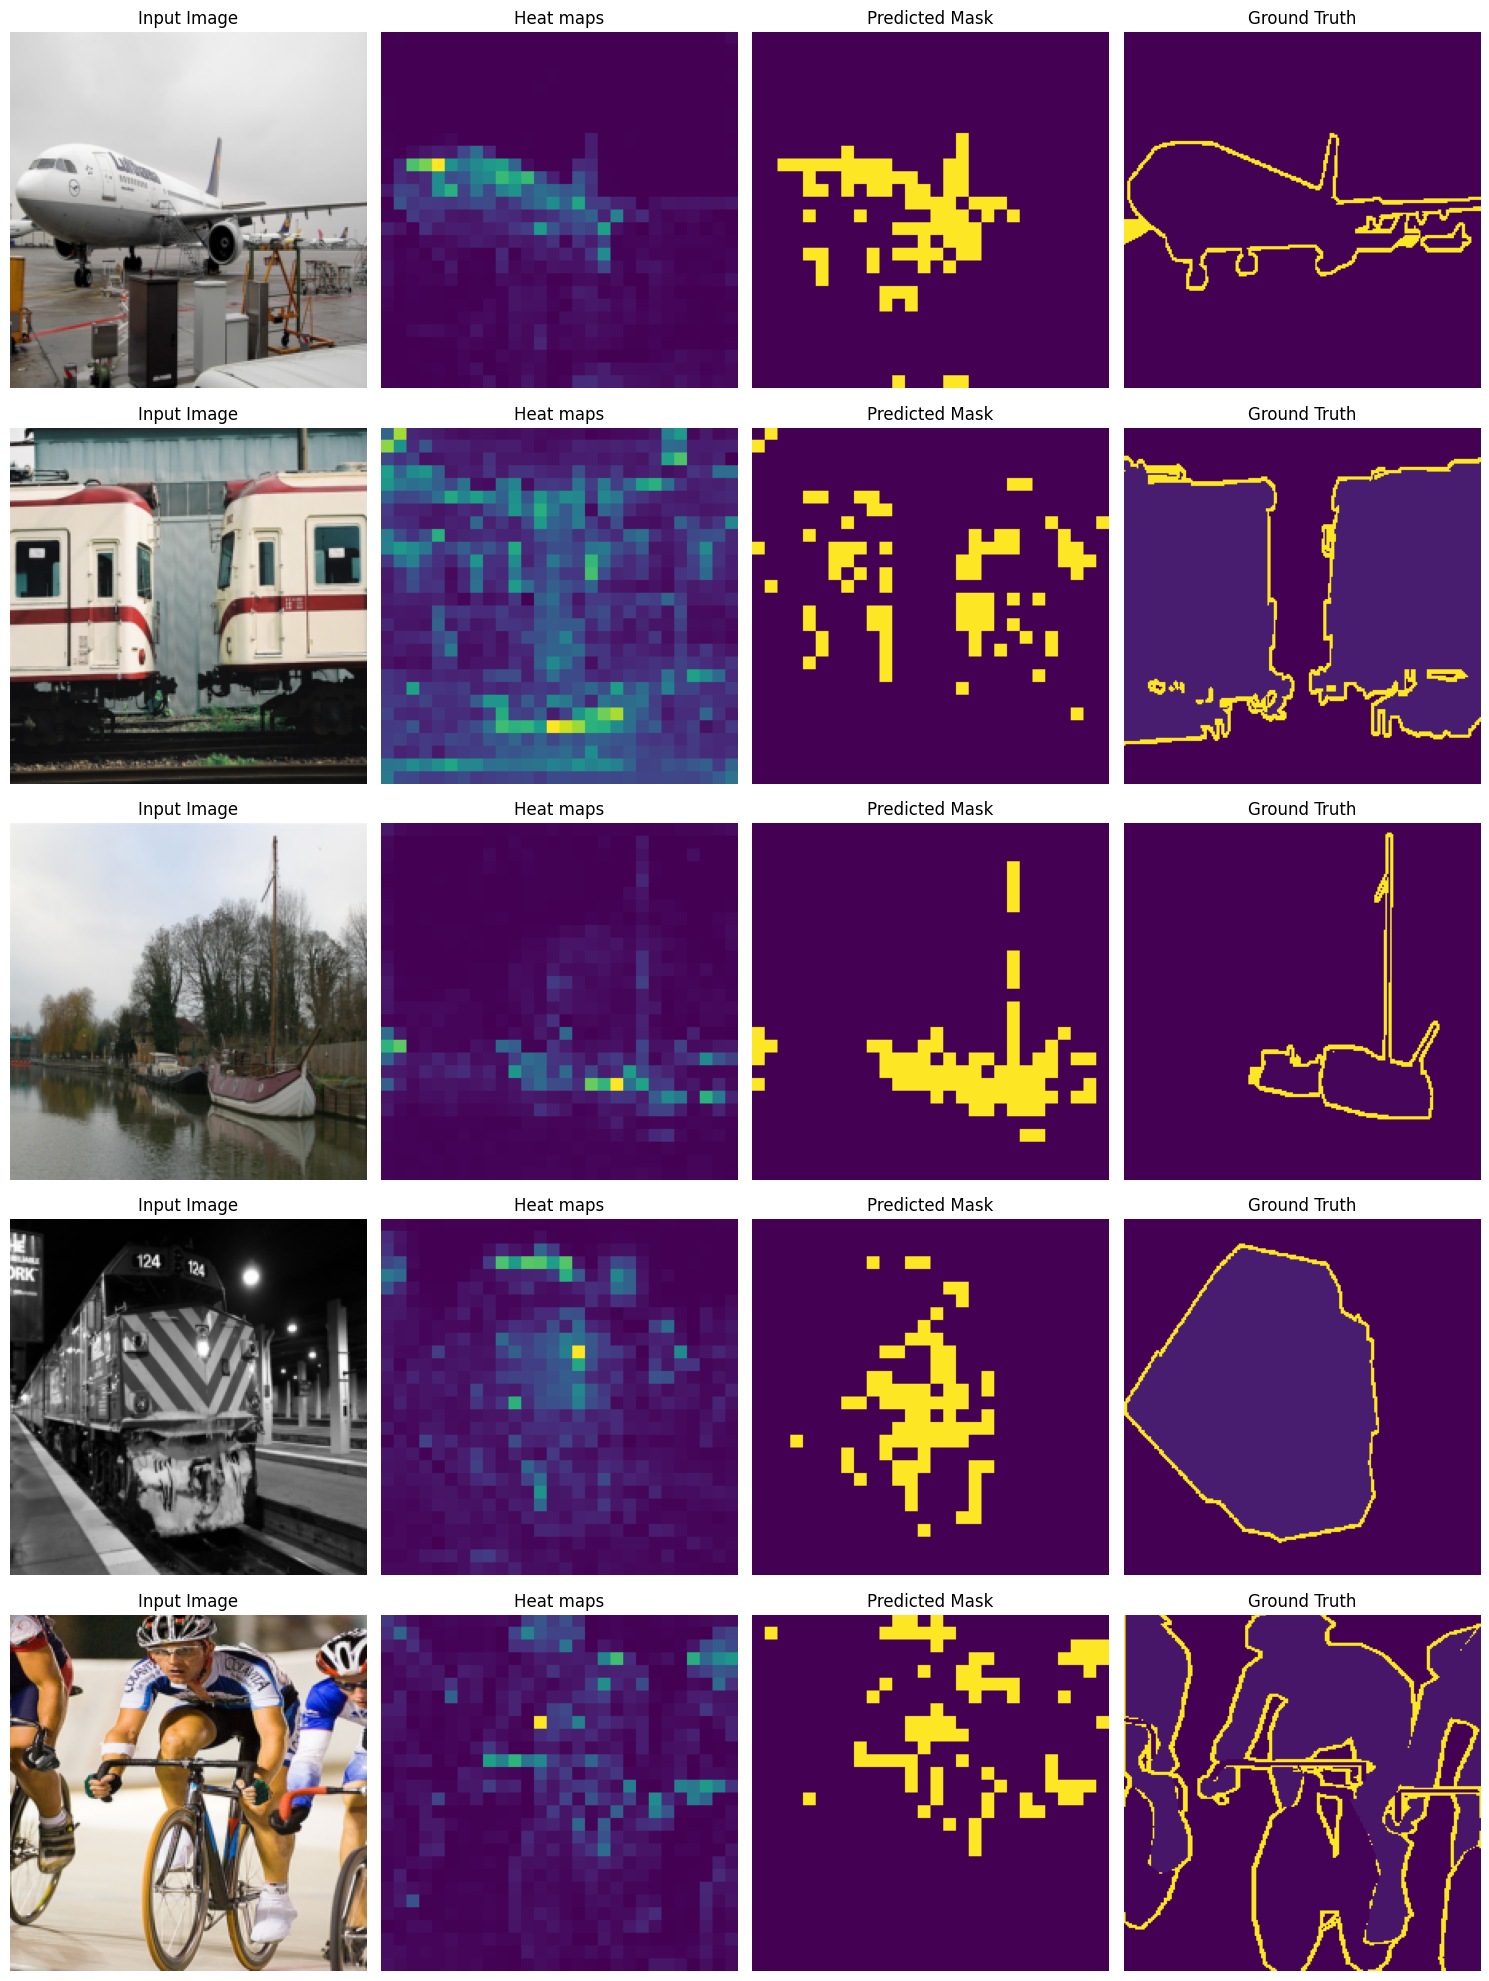

In [8]:
# 8. Main execution flow
if __name__ == "__main__":
    # Initialize dataset
    val_dataset = VOCSegmentation(image_set='val')

    Config.THRESHOLD = best_threshold

    # Run evaluation
    results = evaluate_model(val_dataset)

    # Print results
    print("\n=== Final Evaluation Results ===")
    print(f"IoU: {results['iou']:.4f}")
    print(f"Dice: {results['dice']:.4f}")
    print(f"Accuracy: {results['accuracy']:.4f}")

    # Visualize sample prediction
    x = 4
    num_images_to_show = 5  # or any number you want
    plt.figure(figsize=(15, x * num_images_to_show))

    # Print results
    print("\n=== Final Evaluation Results ===")
    print(f"IoU: {results['iou']:.4f}")
    print(f"Dice: {results['dice']:.4f}")
    print(f"Accuracy: {results['accuracy']:.4f}")

    for idx in range(num_images_to_show):
        sample_img, sample_mask = val_dataset[idx]
        with torch.no_grad():
            inputs = feature_extractor(
                transforms.ToPILImage()(sample_img),
                return_tensors="pt"
            ).pixel_values.to(Config.DEVICE)
            outputs = model(inputs, output_attentions=True)
            pred_mask = generate_segmentation_mask(inputs[0], outputs.attentions[-1][0])
            heat_map = heat_maps(outputs, inputs)
        # Plot
        plt.subplot(num_images_to_show, x, idx*x+1)
        plt.title("Input Image")
        plt.imshow(sample_img.permute(1,2,0))
        plt.axis('off')

        plt.subplot(num_images_to_show, x, idx*x+2)
        plt.title("Heat maps")
        plt.imshow(heat_map[idx])
        plt.axis('off')

        plt.subplot(num_images_to_show, x, idx*x+3)
        plt.title("Predicted Mask")
        plt.imshow(pred_mask)
        plt.axis('off')

        plt.subplot(num_images_to_show, x, idx*x+4)
        plt.title("Ground Truth")
        plt.imshow(sample_mask[0])
        plt.axis('off')
    plt.tight_layout()
    plt.show()
